In [1]:
from warnings import filterwarnings
filterwarnings(action="ignore")

try:
    import evaluate
except:
    !pip install evaluate
    import evaluate

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from torch.optim import AdamW
from huggingface_hub import login
from datasets import load_dataset
from IPython.display import display
from transformers import get_scheduler
from transformers import (
                            AutoTokenizer,
                            AutoModelForSequenceClassification,
                            DataCollatorWithPadding,
                            TrainingArguments, 
                            Trainer
                          )

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("huggingface_api")

login(token=secret_value_0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

2025-06-28 19:44:15.266961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751139855.454014      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751139855.515961      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the dataset
data = load_dataset(path="cornell-movie-review-data/rotten_tomatoes")

README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [3]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [4]:
# Tokenize the data
prep_data = data.map(lambda x: tokenizer(x["text"], 
                                         truncation=True, 
                                         padding=True),
                     batched=True).remove_columns(['text']).rename_columns({"label":"labels"})

prep_data

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1066
    })
})

In [5]:
prep_data.set_format("torch")

train_dataset, val_dataset, test_dataset = prep_data["train"], prep_data["validation"], prep_data["test"]

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=data_collator)

In [7]:
class CustomTrainer:
    def __init__(self, **kwargs):
        self.params = kwargs
        self.best_val_loss = float('inf')
        self.best_val_acc = 0.0
        self.patience_counter = 0

    def train(self):
        for epoch in range(self.params['epoch']): 
            self.params["model"].train()

            train_pred = []
            train_label = []

            train_loss = 0
            
            train_progress = tqdm(self.params["train_dataloader"],
                                  desc=f"Epoch {epoch+1}/{self.params['epoch']} - Training", 
                                  total=len(self.params["train_dataloader"]))

            for batch in train_progress:
                self.params["optimizer"].zero_grad()
                
                input_ids = batch['input_ids'].to(self.params["device"])
                attention_mask = batch['attention_mask'].to(self.params["device"])
                token_type_ids = batch['token_type_ids'].to(self.params["device"])
                labels = batch['labels'].to(self.params['device'])

                output = self.params["model"](input_ids=input_ids, 
                                             attention_mask=attention_mask,
                                             token_type_ids=token_type_ids,
                                             labels=labels)

                loss = output.loss

                train_loss += loss.item()

                pred = torch.argmax(output.logits, dim=-1)

                train_pred.extend(pred.cpu().numpy())
                train_label.extend(labels.cpu().numpy())
                
                loss.backward()
            
                self.params['optimizer'].step()
                
                if self.params.get("lr_scheduler") is not None:
                    self.params["lr_scheduler"].step()

            train_acc = accuracy.compute(predictions=train_pred, references=train_label)["accuracy"]
            train_f1 = f1_score.compute(predictions=train_pred, references=train_label)["f1"]
            average_train_loss = train_loss / len(self.params["train_dataloader"])

            self.params["model"].eval()
            
            val_progress = tqdm(self.params["eval_dataloader"],
                                desc=f"Evaluating", 
                                total=len(self.params["eval_dataloader"]))

            val_pred = []
            val_label = []
            validation_loss = 0
            
            with torch.no_grad():
                for batch in val_progress:
                    input_ids = batch['input_ids'].to(self.params["device"])
                    attention_mask = batch['attention_mask'].to(self.params["device"])
                    token_type_ids = batch['token_type_ids'].to(self.params["device"])
                    labels = batch['labels'].to(self.params["device"])

                    output = self.params["model"](input_ids=input_ids, 
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  labels=labels)

                    loss = output.loss

                    validation_loss += loss.item()

                    pred = torch.argmax(output.logits, dim=-1)

                    val_pred.extend(pred.cpu().numpy())
                    val_label.extend(labels.cpu().numpy())

                val_acc = accuracy.compute(predictions=val_pred, references=val_label)["accuracy"]
                val_f1 = f1_score.compute(predictions=val_pred, references=val_label)["f1"]
                average_val_loss = validation_loss / len(self.params["eval_dataloader"])

            # Get current learning rate
            if self.params["lr_scheduler"] is not None:
                current_lr = self.params['optimizer'].param_groups[0]['lr']

            # Display results
            print(f"\nEpoch {epoch+1}/{self.params['epoch']} Results:") 
            print(f"  Train Loss: {average_train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Train F1: {train_f1:.4f}")
            print(f"  Eval Loss: {average_val_loss:.4f} | Eval Accuracy: {val_acc:.4f} | Eval F1: {val_f1:.4f}")
            print(f"  Current LR: {current_lr:.2e}")
            print("-" * 80)

        return self.params["model"]

In [8]:
optimizer = AdamW(params=model.parameters(), lr=2e-5)

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

accuracy, f1_score = evaluate.load("accuracy"), evaluate.load("f1")

In [9]:
for idx, (name, param) in enumerate(model.named_parameters()):
    if name.startswith(("bert.encoder.layer.11", "classifier")):
        param.requires_grad = True
    else:
        param.requires_grad = False

for idx, (name, param) in enumerate(model.named_parameters()):
    if param.requires_grad:
        print(name)

bert.encoder.layer.11.attention.self.query.weight
bert.encoder.layer.11.attention.self.query.bias
bert.encoder.layer.11.attention.self.key.weight
bert.encoder.layer.11.attention.self.key.bias
bert.encoder.layer.11.attention.self.value.weight
bert.encoder.layer.11.attention.self.value.bias
bert.encoder.layer.11.attention.output.dense.weight
bert.encoder.layer.11.attention.output.dense.bias
bert.encoder.layer.11.attention.output.LayerNorm.weight
bert.encoder.layer.11.attention.output.LayerNorm.bias
bert.encoder.layer.11.intermediate.dense.weight
bert.encoder.layer.11.intermediate.dense.bias
bert.encoder.layer.11.output.dense.weight
bert.encoder.layer.11.output.dense.bias
bert.encoder.layer.11.output.LayerNorm.weight
bert.encoder.layer.11.output.LayerNorm.bias
classifier.weight
classifier.bias


In [10]:
torch_trainer = CustomTrainer(optimizer=optimizer, 
                              train_dataloader=train_dataloader,
                              eval_dataloader=val_dataloader, 
                              model=model.to("cuda:0"),
                              epoch=num_epochs, 
                              device="cuda:0", 
                              lr_scheduler=lr_scheduler)

In [11]:
trained_torch_model = torch_trainer.train()

Evaluating: 100%|██████████| 34/34 [00:02<00:00, 15.20it/s]



Epoch 1/10 Results:
  Train Loss: 0.5412 | Train Accuracy: 0.7136 | Train F1: 0.7168
  Eval Loss: 0.3953 | Eval Accuracy: 0.8321 | Eval F1: 0.8341
  Current LR: 1.80e-05
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 15.01it/s]



Epoch 2/10 Results:
  Train Loss: 0.4016 | Train Accuracy: 0.8200 | Train F1: 0.8170
  Eval Loss: 0.3689 | Eval Accuracy: 0.8433 | Eval F1: 0.8420
  Current LR: 1.60e-05
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 14.96it/s]



Epoch 3/10 Results:
  Train Loss: 0.3684 | Train Accuracy: 0.8445 | Train F1: 0.8415
  Eval Loss: 0.3665 | Eval Accuracy: 0.8396 | Eval F1: 0.8415
  Current LR: 1.40e-05
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 15.07it/s]



Epoch 4/10 Results:
  Train Loss: 0.3556 | Train Accuracy: 0.8438 | Train F1: 0.8411
  Eval Loss: 0.3572 | Eval Accuracy: 0.8433 | Eval F1: 0.8383
  Current LR: 1.20e-05
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 14.97it/s]



Epoch 5/10 Results:
  Train Loss: 0.3443 | Train Accuracy: 0.8519 | Train F1: 0.8492
  Eval Loss: 0.3535 | Eval Accuracy: 0.8518 | Eval F1: 0.8518
  Current LR: 1.00e-05
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 15.14it/s]



Epoch 6/10 Results:
  Train Loss: 0.3348 | Train Accuracy: 0.8551 | Train F1: 0.8524
  Eval Loss: 0.3500 | Eval Accuracy: 0.8508 | Eval F1: 0.8487
  Current LR: 8.00e-06
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 14.94it/s]



Epoch 7/10 Results:
  Train Loss: 0.3290 | Train Accuracy: 0.8610 | Train F1: 0.8588
  Eval Loss: 0.3480 | Eval Accuracy: 0.8527 | Eval F1: 0.8512
  Current LR: 6.00e-06
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 15.01it/s]



Epoch 8/10 Results:
  Train Loss: 0.3240 | Train Accuracy: 0.8646 | Train F1: 0.8623
  Eval Loss: 0.3495 | Eval Accuracy: 0.8518 | Eval F1: 0.8523
  Current LR: 4.00e-06
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 15.04it/s]



Epoch 9/10 Results:
  Train Loss: 0.3203 | Train Accuracy: 0.8635 | Train F1: 0.8614
  Eval Loss: 0.3474 | Eval Accuracy: 0.8565 | Eval F1: 0.8566
  Current LR: 2.00e-06
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 14.85it/s]


Epoch 10/10 Results:
  Train Loss: 0.3163 | Train Accuracy: 0.8678 | Train F1: 0.8669
  Eval Loss: 0.3464 | Eval Accuracy: 0.8518 | Eval F1: 0.8504
  Current LR: 0.00e+00
--------------------------------------------------------------------------------


In [12]:
next(iter(test_dataloader))

{'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), 'input_ids': tensor([[  101,  8295,  2135,  ...,     0,     0,     0],
        [  101, 10862, 12266,  ...,     0,     0,     0],
        [  101,  2009,  1005,  ...,     0,     0,     0],
        ...,
        [  101,  1037,  3969,  ...,     0,     0,     0],
        [  101,  2054,  1005,  ...,     0,     0,     0],
        [  101,  1996,  2364,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [13]:
torch.argmax(trained_torch_model(**{i:j.to("cuda:0") for i, j in next(iter(test_dataloader)).items()}).logits, dim=-1)

tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')

In [14]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
accuracy, f1_score = evaluate.load("accuracy"), evaluate.load("f1")

def ComputeMetric(eval_pred):
    logits, labels = eval_pred
    pred = np.argmax(logits, axis=-1)
    f1 = f1_score.compute(predictions=pred, references=labels)
    acc = accuracy.compute(predictions=pred, references=labels)

    return {"accuracy":acc["accuracy"], "f1_score":f1["f1"]}

#### Training Using Transformers TrainingArguments

In [16]:
training_args = TrainingArguments(output_dir="classification_model",
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  num_train_epochs=10,
                                  weight_decay=.01,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  eval_strategy="epoch",
                                  report_to="none")

model_trainer = Trainer(model=model,
                        args=training_args,
                        data_collator=data_collator,
                        train_dataset=prep_data["train"],
                        eval_dataset=prep_data["validation"], 
                        tokenizer=tokenizer,
                        compute_metrics=ComputeMetric)

In [17]:
model_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,0.320021,0.864916,0.869328
2,0.323100,0.367213,0.855535,0.859745
3,0.323100,0.485416,0.857411,0.862816
4,0.108500,0.640207,0.851782,0.856624
5,0.108500,0.800369,0.844278,0.849365
6,0.033000,0.887812,0.854597,0.855005
7,0.033000,0.916343,0.858349,0.857413
8,0.013200,0.989358,0.848968,0.852429
9,0.013200,1.016931,0.846154,0.850638
10,0.007400,1.007699,0.849906,0.853480


TrainOutput(global_step=2670, training_loss=0.09125010083230693, metrics={'train_runtime': 752.8682, 'train_samples_per_second': 113.3, 'train_steps_per_second': 3.546, 'total_flos': 3415279137441000.0, 'train_loss': 0.09125010083230693, 'epoch': 10.0})

In [18]:
def EvaluateModel(data, model, class_labels=["class:0", "class:1"]):
    output = model.predict(data)
    pred = np.argmax(output.predictions, axis=-1)

    print("Evaluation Score:")
    display(pd.DataFrame([output.metrics]))
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax = ax.flatten()

    # Plot confusion matrix
    sns.heatmap(confusion_matrix(y_true=output.label_ids, y_pred=pred), ax=ax[0], annot=True)
    ax[0].set_title("Confusion Matrix")
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_xticklabels(class_labels)
    ax[0].set_yticklabels(class_labels)

    # Plot Roc curve
    y_prob = torch.nn.functional.softmax(torch.tensor(output.predictions), dim=1).numpy()[:, 1]
    fp, tp, _ = roc_curve(y_true=output.label_ids, y_score=y_prob)
    auc_score = auc(fp, tp)

    ax[1].plot(fp, tp, label=f"auc_score: {auc_score:.2f}")
    ax[1].plot([0, 1], [0, 1], color="black", linestyle="--")
    ax[1].set_title("ROC Curve")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

Evaluation Score:


,test_loss,test_accuracy,test_f1_score,test_runtime,test_samples_per_second,test_steps_per_second
0,0.338332,0.863039,0.8663,2.3987,444.404,14.174


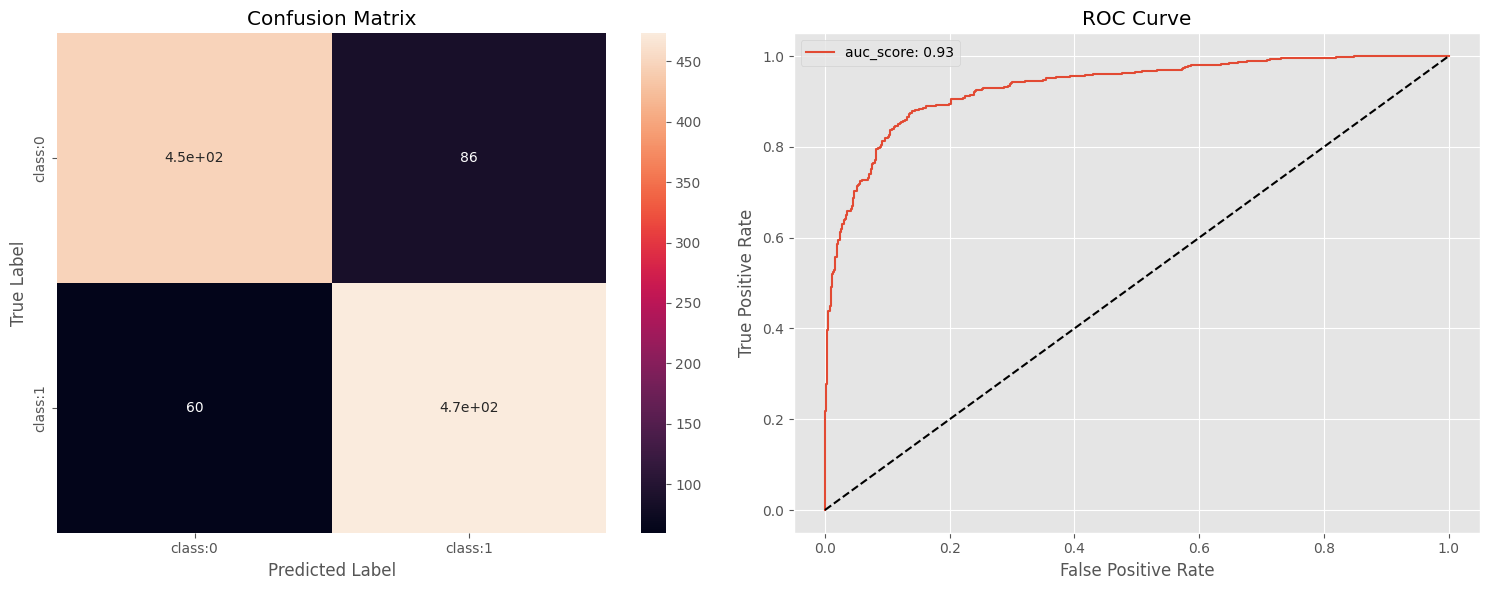

In [19]:
EvaluateModel(data=prep_data["test"], model=model_trainer)

#### Freezing layers

In [20]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

for idx, (name, param) in enumerate(model.named_parameters()):
    if idx >= 101:
        param.requires_grad = True
    else:
        param.requires_grad = False

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
#### Check number of trainable parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print("Trainable parameters ->", name)

Trainable parameters -> bert.encoder.layer.6.attention.self.query.weight
Trainable parameters -> bert.encoder.layer.6.attention.self.query.bias
Trainable parameters -> bert.encoder.layer.6.attention.self.key.weight
Trainable parameters -> bert.encoder.layer.6.attention.self.key.bias
Trainable parameters -> bert.encoder.layer.6.attention.self.value.weight
Trainable parameters -> bert.encoder.layer.6.attention.self.value.bias
Trainable parameters -> bert.encoder.layer.6.attention.output.dense.weight
Trainable parameters -> bert.encoder.layer.6.attention.output.dense.bias
Trainable parameters -> bert.encoder.layer.6.attention.output.LayerNorm.weight
Trainable parameters -> bert.encoder.layer.6.attention.output.LayerNorm.bias
Trainable parameters -> bert.encoder.layer.6.intermediate.dense.weight
Trainable parameters -> bert.encoder.layer.6.intermediate.dense.bias
Trainable parameters -> bert.encoder.layer.6.output.dense.weight
Trainable parameters -> bert.encoder.layer.6.output.dense.bias


In [22]:
tuned_model_arg = TrainingArguments(output_dir="fine-tuned-model",
                                    per_device_train_batch_size=32, 
                                    per_device_eval_batch_size=32,
                                    learning_rate=2e-5,
                                    weight_decay=.01,
                                    num_train_epochs=10,
                                    load_best_model_at_end=True, 
                                    report_to="none",
                                    eval_strategy="epoch",
                                    save_strategy="epoch")

tuned_model_trainer = Trainer(model=model, 
                              args=tuned_model_arg,
                              train_dataset=prep_data["train"], 
                              eval_dataset=prep_data["validation"],
                              data_collator=data_collator, 
                              compute_metrics=ComputeMetric,
                              tokenizer=tokenizer)

In [25]:
# tuned_model_trainer.train()

Evaluation Score:


,test_loss,test_accuracy,test_f1_score,test_runtime,test_samples_per_second,test_steps_per_second
0,0.872509,0.835835,0.83475,2.2928,464.936,14.829


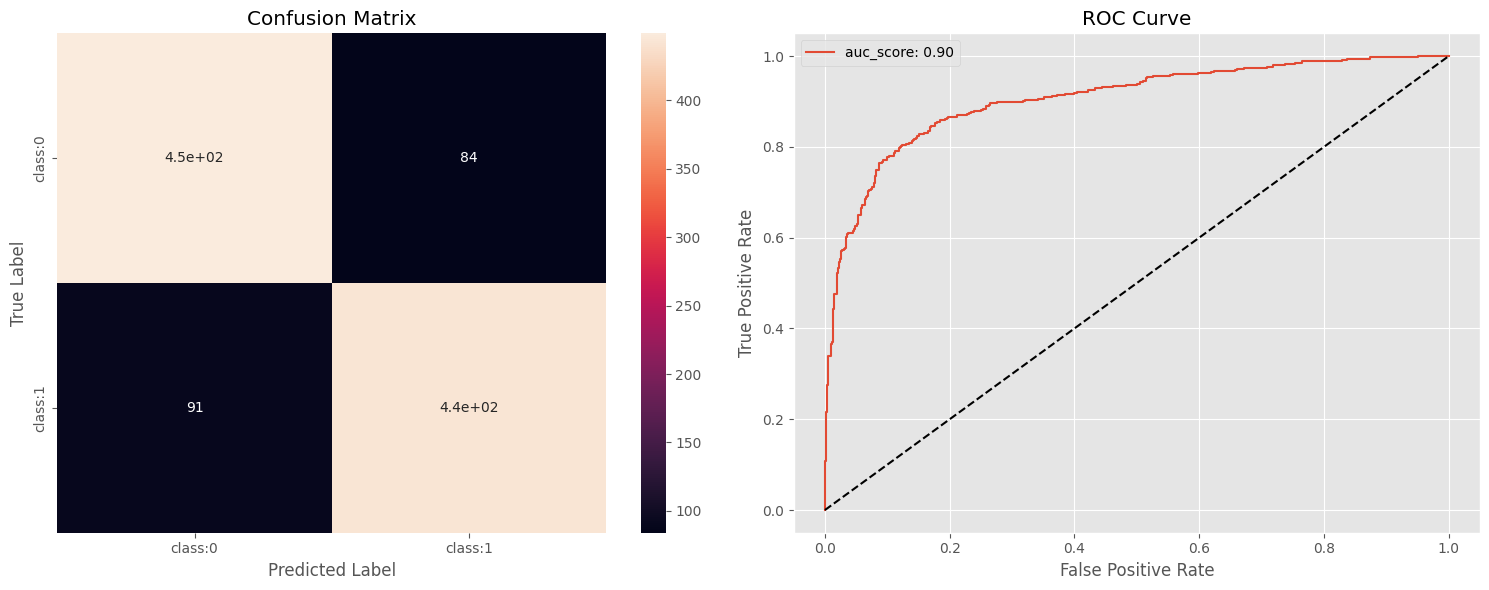

In [24]:
EvaluateModel(data=prep_data["test"], model=tuned_model_trainer)